In [2]:
import nltk
import re
import unicodedata
import numpy as np
from nltk.tag import CRFTagger
from gensim.models import KeyedVectors
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from itertools import product

nltk.download('conll2002')
nltk.download('stopwords')
from nltk.corpus import conll2002, stopwords

[nltk_data] Downloading package conll2002 to
[nltk_data]     C:\Users\baske\AppData\Roaming\nltk_data...
[nltk_data]   Package conll2002 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\baske\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# ============================
# Load Datasets and Word2Vec Model
# ============================
print("Cargando datos y modelo de Word2Vec...")
tr_sp = conll2002.iob_sents('esp.train')  # Train Español
test_sp = conll2002.iob_sents('esp.testb')  # Test Español
stop_words = set(stopwords.words('spanish'))
word2vec_model = KeyedVectors.load_word2vec_format('model.bin', binary=True)
print("Modelo y datos cargados correctamente!")

Cargando datos y modelo de Word2Vec...
Modelo y datos cargados correctamente!


In [5]:
# ============================
# Feature Extraction Function
# ============================
def features(tokens, idx, use_embeddings=True, use_context=True, use_punctuation=True):
    """
    Extrae características de una palabra con opciones para habilitar/deshabilitar características específicas.
    """
    pattern = re.compile(r"\d")
    token = tokens[idx]
    feature_list = []

    if not token:
        return feature_list

    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    if re.search(pattern, token) is not None:
        feature_list.append("HAS_NUM")

    if use_punctuation:
        punc_cat = {"Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"}
        if all(unicodedata.category(x) in punc_cat for x in token):
            feature_list.append("PUNCTUATION")

    if len(token) > 1:
        feature_list.append("SUF_" + token[-1:])
        feature_list.append("PREF_" + token[:1])
    if len(token) > 2:
        feature_list.append("SUF_" + token[-2:])
        feature_list.append("PREF_" + token[:2])
    if len(token) > 3:
        feature_list.append("SUF_" + token[-3:])
        feature_list.append("PREF_" + token[:3])

    if use_context:
        if idx > 0:
            prev_token = tokens[idx - 1]
            feature_list.append("PREV_WORD_" + prev_token)
        else:
            feature_list.append("BOS")

        if idx < len(tokens) - 1:
            next_token = tokens[idx + 1]
            feature_list.append("NEXT_WORD_" + next_token)
        else:
            feature_list.append("EOS")

    if use_embeddings:
        try:
            embedding_vector = word2vec_model[token.lower()]
            for i, value in enumerate(embedding_vector[:10]):
                feature_list.append(f"EMBEDDING_DIM_{i}_{value:.4f}")
        except KeyError:
            feature_list.append("UNK_EMBEDDING")

    feature_list.append("WORD_" + token)
    return feature_list


In [6]:
# ============================
# Codification Conversion Functions
# ============================
def convert_to_bio(sentences):
    return [[(word, ner) for word, pos, ner in sent] for sent in sentences]

def convert_to_biow(sentences):
    converted_sentences = []
    for sent in sentences:
        converted_sent = []
        for i, (word, pos, ner) in enumerate(sent):
            if ner == "O":
                converted_sent.append((word, ner))
            elif (i == 0 or sent[i-1][2] != ner) and (i == len(sent)-1 or sent[i+1][2] != ner):
                converted_sent.append((word, f"W-{ner.split('-')[-1]}"))
            elif i == 0 or sent[i-1][2] != ner:
                converted_sent.append((word, f"B-{ner.split('-')[-1]}"))
            else:
                converted_sent.append((word, f"I-{ner.split('-')[-1]}"))
        converted_sentences.append(converted_sent)
    return converted_sentences

def convert_to_io(sentences):
    return [[(word, ner if ner != "O" else "O") for word, pos, ner in sent] for sent in sentences]

def convert_to_bioes(sentences):
    converted_sentences = []
    for sent in sentences:
        converted_sent = []
        for i, (word, pos, ner) in enumerate(sent):
            if ner == "O":
                converted_sent.append((word, ner))
            elif (i == 0 or sent[i-1][2] != ner) and (i == len(sent)-1 or sent[i+1][2] != ner):
                converted_sent.append((word, f"S-{ner.split('-')[-1]}"))
            elif i == 0 or sent[i-1][2] != ner:
                converted_sent.append((word, f"B-{ner.split('-')[-1]}"))
            elif i == len(sent)-1 or sent[i+1][2] != ner:
                converted_sent.append((word, f"E-{ner.split('-')[-1]}"))
            else:
                converted_sent.append((word, f"I-{ner.split('-')[-1]}"))
        converted_sentences.append(converted_sent)
    return converted_sentences


In [5]:
# ============================
# Hyperparameter Optimization (Greedy Search)
# ============================
print("Iniciando búsqueda de hiperparámetros para BIO...")
best_f1 = 0
best_params = {}
param_grid = {
    "use_embeddings": [True, False],
    "use_context": [True, False],
    "use_punctuation": [True, False]
}
for params in product(*param_grid.values()):
    param_dict = dict(zip(param_grid.keys(), params))
    train_sents = convert_to_bio(tr_sp)
    test_sents = convert_to_bio(test_sp)
    
    def temp_features(tokens, idx):
        return features(tokens, idx, **param_dict)
    
    ct = CRFTagger(feature_func=temp_features)
    ct.train(train_sents, 'bio_model.crf.tagger')
    predicted_sents = ct.tag_sents([[word for word, tag in sent] for sent in test_sents])
    
    true_entities = []
    predicted_entities = []
    for true_sent, pred_sent in zip(test_sents, predicted_sents):
        for (word_t, tag_t), (word_p, tag_p) in zip(true_sent, pred_sent):
            if tag_t != 'O':  # <- Aquí filtrem les paraules que són entitats en el conjunt de test
                true_entities.append(tag_t)
                predicted_entities.append(tag_p)
            elif tag_p != 'O' and tag_t == 'O': # <- Tmb agafem les entitats que el model prediu com entitats pero no ho són.
                true_entities.append(tag_t)
                predicted_entities.append(tag_p)
    
    report = classification_report(true_entities, predicted_entities, output_dict=True)
    f1_score = report["weighted avg"]["f1-score"]
    
    if f1_score > best_f1:
        best_f1 = f1_score
        best_params = param_dict

print(f"Mejores hiperparámetros encontrados: {best_params} con F1-score: {best_f1:.4f}")


Iniciando búsqueda de hiperparámetros para BIO...
Mejores hiperparámetros encontrados: {'use_embeddings': True, 'use_context': True, 'use_punctuation': False} con F1-score: 0.7803


In [6]:
# ============================
# Train Models with Optimal Parameters for Different Codifications
# ============================
print("Entrenando modelos con diferentes codificaciones...")
codifications = {"BIO": convert_to_bio, "IO": convert_to_io, "BIOW": convert_to_biow, "BIOES": convert_to_bioes}
results = {}

for cod_name, cod_func in codifications.items():
    train_sents = cod_func(tr_sp)
    test_sents = cod_func(test_sp)
    
    def final_features(tokens, idx):
        return features(tokens, idx, **best_params)
    
    ct = CRFTagger(feature_func=final_features)
    ct.train(train_sents, f'{cod_name}_model.crf.tagger')
    predicted_sents = ct.tag_sents([[word for word, tag in sent] for sent in test_sents])
    
    true_entities = []
    predicted_entities = []
    for true_sent, pred_sent in zip(test_sents, predicted_sents):
        for (word_t, tag_t), (word_p, tag_p) in zip(true_sent, pred_sent):
            if tag_t != 'O':  # <- Aquí filtrem les paraules que són entitats en el conjunt de test
                true_entities.append(tag_t)
                predicted_entities.append(tag_p)
            elif tag_p != 'O' and tag_t == 'O': # <- Tmb agafem les entitats que el model prediu com entitats pero no ho són.
                true_entities.append(tag_t)
                predicted_entities.append(tag_p)
    
    report = classification_report(true_entities, predicted_entities, output_dict=True, digits=4)
    results[cod_name] = {
        "classification_report": report,
        "confusion_matrix": confusion_matrix(true_entities, predicted_entities)
    }


Entrenando modelos con diferentes codificaciones...


Comparando resultados de las codificaciones...

Tabla comparativa:
       Precision    Recall  F1-Score
BIO     0.792606  0.771267  0.780346
IO      0.792606  0.771267  0.780346
BIOW    0.774790  0.758057  0.764702
BIOES   0.767499  0.748384  0.756110


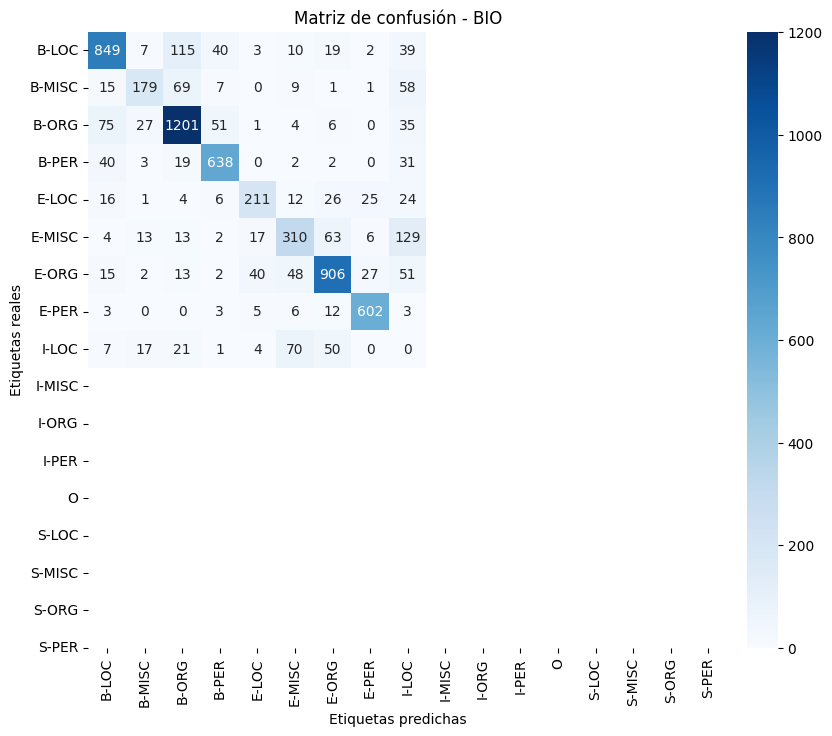

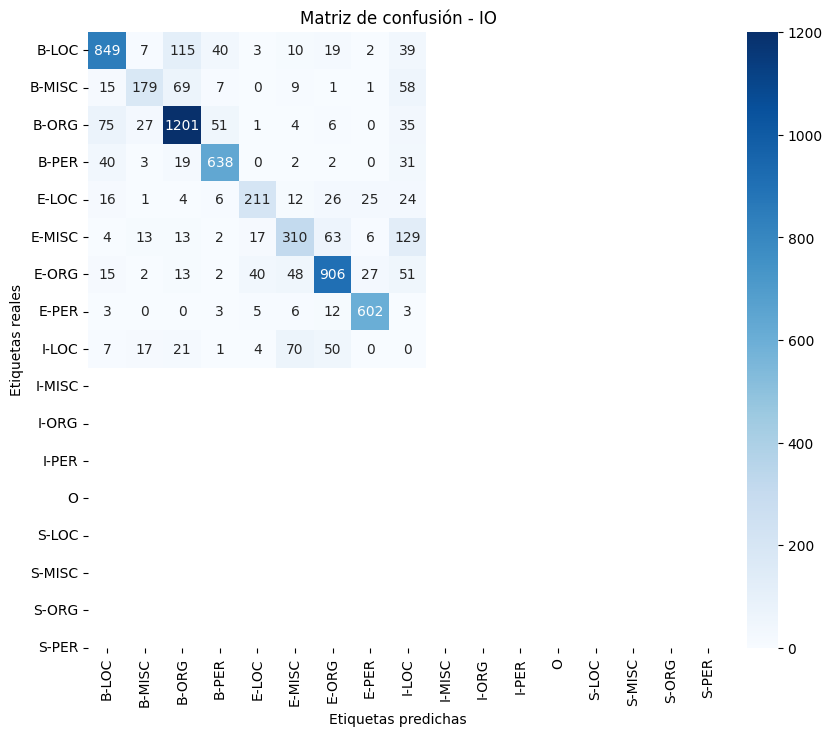

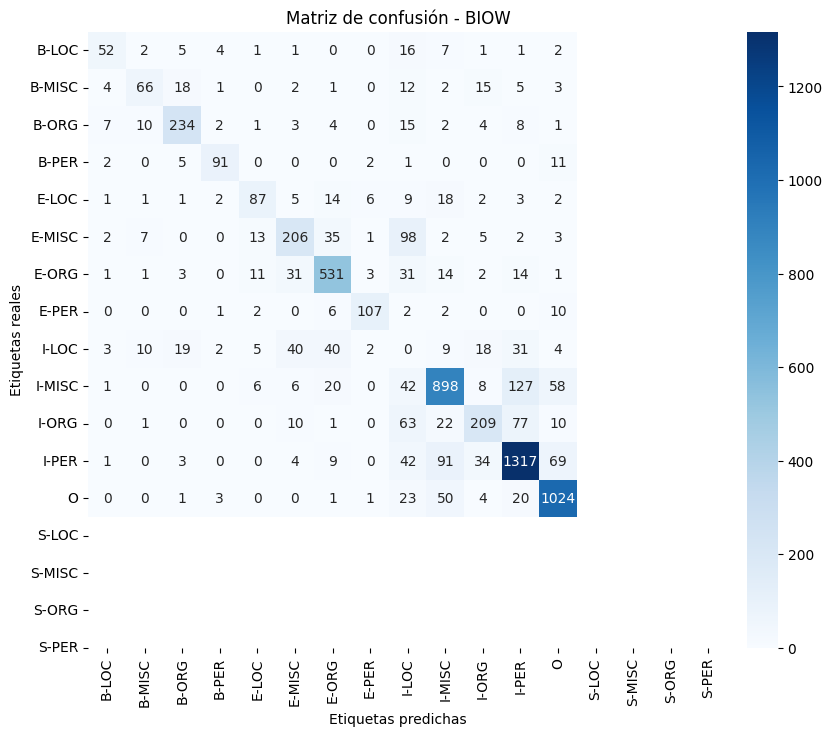

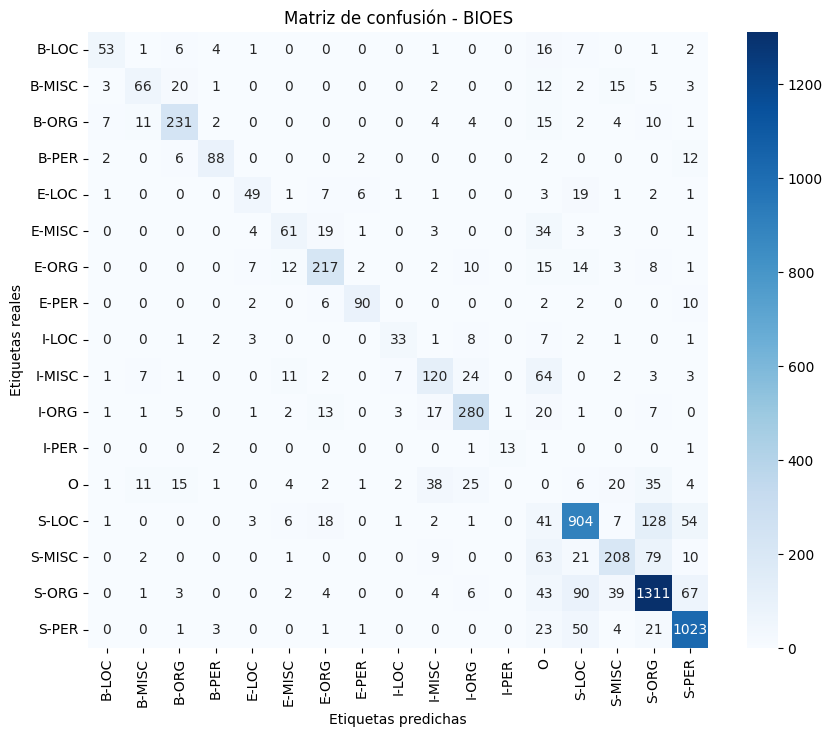

In [7]:
# ============================
# Display Results
# ============================
print("Comparando resultados de las codificaciones...")
comparison_table = pd.DataFrame({
    cod_name: {
        "Precision": results[cod_name]["classification_report"]["weighted avg"]["precision"],
        "Recall": results[cod_name]["classification_report"]["weighted avg"]["recall"],
        "F1-Score": results[cod_name]["classification_report"]["weighted avg"]["f1-score"]
    }
    for cod_name in results.keys()
}).T

print("\nTabla comparativa:")
print(comparison_table)

for cod_name, data in results.items():
    cm = data["confusion_matrix"]
    labels = sorted(set(true_entities + predicted_entities))
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Etiquetas predichas')
    plt.ylabel('Etiquetas reales')
    plt.title(f'Matriz de confusión - {cod_name}')
    plt.show()

In [ ]:
best_params={'use_embeddings': True, 'use_context': True, 'use_punctuation': False}
# ============================
# Load Datasets and Word2Vec Model
# ============================
print("Cargando datos y modelo de Word2Vec...")
tr_ne = conll2002.iob_sents('ned.train') # Train Neerlandés
test_ne = conll2002.iob_sents('ned.testb') # Test Neerlandés
stop_words = set(stopwords.words('dutch'))
word2vec_model = KeyedVectors.load_word2vec_format('model_ned.bin', binary=True)
print("Modelo y datos cargados correctamente!")
# ============================
# Train Models with Optimal Parameters for Different Codifications (Neerlandes)
# ============================
print("Entrenando modelos con diferentes codificaciones...")
codifications = {"BIO": convert_to_bio, "IO": convert_to_io, "BIOW": convert_to_biow, "BIOES": convert_to_bioes}
results = {}

for cod_name, cod_func in codifications.items():
    train_sents = cod_func(tr_ne)
    test_sents = cod_func(test_ne)
    
    def final_features(tokens, idx):
        return features(tokens, idx, **best_params)
    
    ct = CRFTagger(feature_func=final_features)
    ct.train(train_sents, f'{cod_name}_model.crf.tagger')
    predicted_sents = ct.tag_sents([[word for word, tag in sent] for sent in test_sents])
    
    true_entities = []
    predicted_entities = []
    for true_sent, pred_sent in zip(test_sents, predicted_sents):
        for (word_t, tag_t), (word_p, tag_p) in zip(true_sent, pred_sent):
            if tag_t != 'O':  # <- Aquí filtrem les paraules que són entitats en el conjunt de test
                true_entities.append(tag_t)
                predicted_entities.append(tag_p)
            elif tag_p != 'O' and tag_t == 'O': # <- Tmb agafem les entitats que el model prediu com entitats pero no ho són.
                true_entities.append(tag_t)
                predicted_entities.append(tag_p)
    
    report = classification_report(true_entities, predicted_entities, output_dict=True, digits=4)
    results[cod_name] = {
        "classification_report": report,
        "confusion_matrix": confusion_matrix(true_entities, predicted_entities)
    }


Cargando datos y modelo de Word2Vec...
Modelo y datos cargados correctamente!
Entrenando modelos con diferentes codificaciones...


c:\Users\baske\.pyenv\pyenv-win\versions\3.11.9\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\baske\.pyenv\pyenv-win\versions\3.11.9\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\baske\.pyenv\pyenv-win\versions\3.11.9\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

In [8]:
# ============================
# Display Results
# ============================
print("Comparando resultados de las codificaciones...")
comparison_table = pd.DataFrame({
    cod_name: {
        "Precision": results[cod_name]["classification_report"]["weighted avg"]["precision"],
        "Recall": results[cod_name]["classification_report"]["weighted avg"]["recall"],
        "F1-Score": results[cod_name]["classification_report"]["weighted avg"]["f1-score"]
    }
    for cod_name in results.keys()
}).T

print("\nTabla comparativa:")
print(comparison_table)

Comparando resultados de las codificaciones...

Tabla comparativa:
       Precision    Recall  F1-Score
BIO     0.751763  0.718433  0.732280
IO      0.751763  0.718433  0.732280
BIOW    0.743899  0.709156  0.721436
BIOES   0.743652  0.707176  0.717797
